In [3]:
from __future__ import print_function

from IPython import display

import math
import matplotlib
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from numpy import radians, cos, sin, arcsin, arccos, sqrt, pi, arctan2, degrees, arctan
import itertools

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
tqdm.pandas(tqdm_notebook)

import osrm
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import metrics

from xgboost import XGBRegressor

pd.options.display.max_rows = 10

In [4]:
df = pd.read_csv('all_withspeed.tsv',parse_dates=[2])
df.drop(df.columns[0], axis=1, inplace = True)

In [5]:
grouper = df.groupby('trip id')

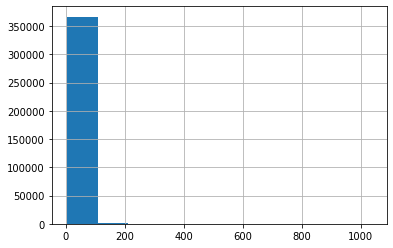

In [6]:
df[df['time_elapsed_seconds'] > 4]['time_elapsed_seconds'].hist()

In [7]:
df[df['speed kmh'] > 150]

,trip id,iso timestamp,latitude,longitude,distance_travelled,time_elapsed_seconds,speed m/s,speed kmh
901,25,2007-01-02 00:47:06+00:00,37.769229,-122.397556,0.176986,4.0,44.246530,159.287510
1522,38,2007-01-07 16:02:30+00:00,37.769852,-122.421149,0.167707,4.0,41.926721,150.936195
3143,75,2007-01-05 06:37:30+00:00,37.797065,-122.435534,0.342549,4.0,85.637281,308.294212
3772,90,2007-01-03 22:18:03+00:00,37.770069,-122.389482,0.505344,12.0,42.111971,151.603097
4800,115,2007-01-06 16:37:27+00:00,37.787824,-122.403667,0.183029,4.0,45.757294,164.726258
...,...,...,...,...,...,...,...,...
1122588,24866,2007-01-04 06:07:18+00:00,37.777878,-122.401372,0.175524,4.0,43.881065,157.971834
1125453,24930,2007-01-07 07:59:58+00:00,37.802203,-122.425453,0.466617,4.0,116.654234,419.955241
1125708,24935,2007-01-01 02:53:09+00:00,37.762851,-122.429794,0.265298,3.0,88.432713,318.357765
1127649,24979,2007-01-06 01:54:01+00:00,37.794081,-122.426424,0.160344,1.0,160.343764,577.237552


In [ ]:
i = 0
fig, ax = plt.subplots()
for name, val in tqdm(grouper):
    val.plot(kind = 'scatter',x = 'longitude', y = 'latitude', c = 'speed kmh', ax = ax, legend = False, figsize = (10,12))
    i+= 1
    if i >10:
        break

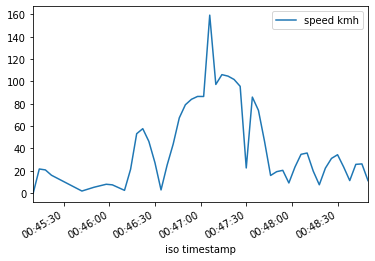

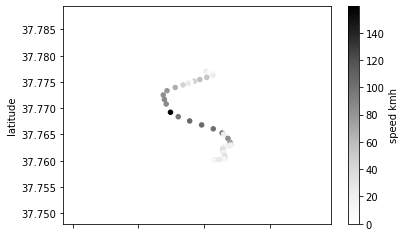

In [10]:
df[df['trip id'] == 25].plot(x = 'iso timestamp', y ='speed kmh')
df[df['trip id'] == 25].plot(kind = 'scatter', y = 'latitude', x = 'longitude' ,c = 'speed kmh')

In [16]:
def running_mean(x ,N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/float(N)

def kalman_oneD(kinematics, col, plot):
    n_iter = kinematics.shape[0]
    sz = (n_iter,)
    z = kinematics[col].values
    Q = 9e-5 #process variance
    xhat=np.zeros(sz) #a posteri x estimate
    P=np.zeros(sz) #a priori error estimate
    xhatminus=np.zeros(sz)
    Pminus=np.zeros(sz)
    K=np.zeros(sz)

    R = 0.045**2 #measurement variance

    xhat[0] = z[0]
    P[0] = 1.0

    for k in range(1, n_iter):
        #time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + Q
        #measurement update
        K[k] = Pminus[k]/(Pminus[k] + R)
        xhat[k] = xhatminus[k] + K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    rmk = running_mean(xhat, 10)
    rm = running_mean(z, 15)
    
    
    if plot == True:
        plt.figure(figsize=(20,10))
        plt.plot(kinematics['iso timestamp'],z, 'k+', label = 'derived speed')
        plt.plot(kinematics['iso timestamp'],kinematics[col].rolling(window = 15).mean(), 'g-', label = 'pandas rolling')
        plt.plot(kinematics['iso timestamp'], xhat, 'b-', label = 'speed estimate')
#         plt.plot(kinematics['iso timestamp'], kinematics['knots AIS'], 'y-', label = 'AIS speed')
        plt.plot(kinematics['iso timestamp'].iloc[:len(rmk)], rmk, label = 'runningmean kalman')
        plt.plot(kinematics['iso timestamp'].iloc[:len(rm)], rm, 'r-', label = 'runningmean raw')
        plt.xlabel('Time')
        plt.ylabel('Speed')
        plt.legend()

    rmk = np.append(rmk, xhat[-9:])
    
    return rmk


array([13.02448679, 14.97622457, 15.50966773, 16.45622642, 17.52119383,
       18.56852537, 19.84599843, 21.58058272, 24.13303417, 27.66718195,
       31.7064042 , 35.58533023, 39.25902973, 44.37464588, 49.8485177 ,
       56.243861  , 62.93658244, 69.4541522 , 75.2690219 , 78.90642925,
       81.89051716, 84.07216366, 85.07913017, 83.1726789 , 80.14737846,
       76.0715401 , 70.95509537, 65.32213816, 59.60402935, 55.22463617,
       50.4203778 , 45.26396776, 40.62957794, 37.16401077, 34.64342779,
       32.65816589, 31.09003056, 29.86562896, 28.71066268, 27.30629876,
       28.55900287, 27.38689662, 28.0912744 , 29.28728543, 28.17844215,
       24.96943166, 25.12435721, 25.32608427, 22.65239964])

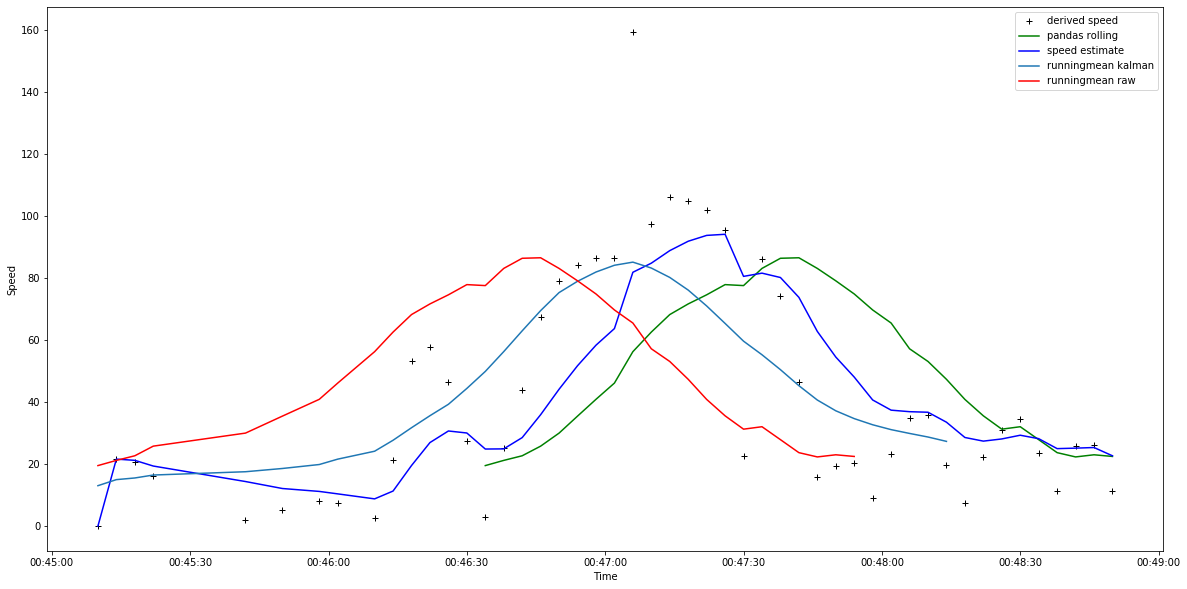

In [17]:
kalman_oneD(df[df['trip id'] == 25], 'speed kmh', plot = 1)

In [3]:
grouper = df.groupby('trip id')

In [4]:
taxi2 = []
for name, val in tqdm(grouper):
    prod = []
    for pair in itertools.combinations(val.iloc[:,1:].values,2):
        prod.append(pair)
    try:
        foo = pd.DataFrame.from_records(prod)
        foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)
        taxi2.append(foo)
    except KeyError:
        pass

100%|██████████| 24999/24999 [05:30<00:00, 75.53it/s] 


In [5]:
dump(taxi2, '/mnt/hgfs/FYP/allpairs_speed')

['/mnt/hgfs/FYP/allpairs_speed']

In [2]:
taxi2 = load('/mnt/hgfs/FYP/allpairs_speed')

In [3]:
taxi2[1]

,0,1,2,3,4,5,6,0,1,2,3,4,5,6
0,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:39+00:00,37.800155,-122.434101,0.051678,4.0,12.919610,46.510594
1,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:43+00:00,37.800160,-122.434430,0.028944,4.0,7.236004,26.049615
2,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:47+00:00,37.800378,-122.434527,0.025724,4.0,6.430954,23.151435
3,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:51+00:00,37.800738,-122.434598,0.040559,4.0,10.139675,36.502829
4,2007-01-06 06:22:35+00:00,37.800224,-122.433520,0.000000,0.0,0.000000,0.000000,2007-01-06 06:22:55+00:00,37.800938,-122.434650,0.022729,4.0,5.682216,20.455978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2007-01-06 06:23:55+00:00,37.800395,-122.436172,0.030915,4.0,7.728735,27.823444,2007-01-06 06:24:07+00:00,37.800169,-122.436130,0.006682,8.0,0.835287,3.007033
149,2007-01-06 06:23:55+00:00,37.800395,-122.436172,0.030915,4.0,7.728735,27.823444,2007-01-06 06:25:03+00:00,37.800066,-122.436167,0.011919,56.0,0.212836,0.766211
150,2007-01-06 06:23:59+00:00,37.800228,-122.436116,0.019232,4.0,4.807962,17.308664,2007-01-06 06:24:07+00:00,37.800169,-122.436130,0.006682,8.0,0.835287,3.007033
151,2007-01-06 06:23:59+00:00,37.800228,-122.436116,0.019232,4.0,4.807962,17.308664,2007-01-06 06:25:03+00:00,37.800066,-122.436167,0.011919,56.0,0.212836,0.766211


In [5]:
# fofoo = []
# for name, val in tqdm(grouper):
#     prod = []
#     for pair in itertools.combinations(val.iloc[:,1:].values,2):
#         prod.append(pair)
#     fofoo.append(prod)
# flat_list = [item for sublist in fofoo for item in sublist]
# foo = pd.DataFrame(flat_list)
# foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)    

100%|██████████| 24999/24999 [00:36<00:00, 687.10it/s]


In [ ]:
foo = pd.concat(taxi2)

In [ ]:
col_names = ['pickup_datetime','pickup_latitude', 'pickup_longitude'
         ,'dropoff_datetime','dropoff_latitude', 'dropoff_longitude']
# foo = pd.concat([foo[0].progress_apply(pd.Series), foo[1].apply(pd.Series)], axis = 1)
# foo = pd.concat([pd.DataFrame(foo[0].values.tolist()), pd.DataFrame(foo[1].values.tolist())], axis = 1)
foo.columns = col_names

In [ ]:
foo.to_csv('./allpairs.csv')

In [ ]:
foo.sample(10000).plot(x = 'pickup_latitude', y = 'pickup_longitude')

In [ ]:
chunk = 0
taxi = []
for df in pd.read_csv('allpairs.csv', chunksize = 1000000):
    taxi.append(df)
    chunk += 1
    if chunk == 5:
        break
    

In [ ]:
df = pd.read_csv('allpairs.csv')

In [ ]:
df2 = df.sample(frac = 1)

In [ ]:
df2.to_csv('/mnt/hgfs/FYP/allpairs_shuffled.csv')